In [1]:
%load_ext cython
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from scipy.integrate import quad

# dev

In [2]:
%%cython -c=-fopenmp -lomp -lgsl -lgslcblas -L=/usr/local/lib/
# cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
cimport numpy as cnp
import numpy as np
from cython_gsl cimport *
from libc.math cimport sqrt, cos, sin, exp, pi, tanh
from libc.stdlib cimport rand, RAND_MAX
from cython.parallel import prange, parallel

ctypedef cnp.complex128_t complex_t
ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint64_t uint_t

cdef float_t lens_re(float_t xx, void* params) nogil:
    cdef:
        float_t x = (<float_t*> params)[0], z = (<float_t*> params)[1]
        float_t wl = (<float_t*> params)[2], f = (<float_t*> params)[3]
        float_t alpha = (<float_t*> params)[4]
    return cos(pi * xx**2 / wl * (1 / f - 1 / z) + 2 * pi / wl / z * x * xx - alpha * 1e9 * (xx / f)**3)

cdef float_t lens_im(float_t xx, void* params) nogil:
    cdef:
        float_t x = (<float_t*> params)[0], z = (<float_t*> params)[1]
        float_t wl = (<float_t*> params)[2], f = (<float_t*> params)[3]
        float_t alpha = (<float_t*> params)[4]
    return -sin(pi * xx**2 / wl * (1 / f - 1 / z) + 2 * pi / wl / z * x * xx - alpha * 1e9 * (xx / f)**3)

cdef float_t aperture_re(float_t xx, void* params) nogil:
    cdef:
        float_t x = (<float_t*> params)[0], z = (<float_t*> params)[1], wl = (<float_t*> params)[2]
    return cos(pi / wl / z * (x - xx)**2)

cdef float_t aperture_im(float_t xx, void* params) nogil:
    cdef:
        float_t x = (<float_t*> params)[0], z = (<float_t*> params)[1], wl = (<float_t*> params)[2]
    return sin(pi / wl / z * (x - xx)**2)

cdef float_t gsl_quad(gsl_function func, float_t a, float_t b, float_t eps_abs, float_t eps_rel, int_t limit) nogil:
    cdef:
        float_t result, error
        gsl_integration_workspace * W
    W = gsl_integration_workspace_alloc(limit)
    gsl_integration_qag(&func, a, b, eps_abs, eps_rel, limit, GSL_INTEG_GAUSS51, W, &result, &error)
    gsl_integration_workspace_free(W)
    return result

cdef complex_t lens_wp(float_t x, float_t defoc, float_t wl, float_t f, float_t alpha, float_t ap) nogil:
    cdef:
        float_t ph = 2 * pi * (f + defoc) / wl + pi * x**2 / wl / (f + defoc), re, im
        float_t params[5]
        int_t fn = <int_t> (ap**2 / wl / (f + defoc))
        gsl_function func
    params[0] = x; params[1] = f + defoc; params[2] = wl; params[3] = f; params[4] = alpha
    func.function = &lens_re; func.params = params
    re = gsl_quad(func, -ap / 2, ap / 2, 1e-9, 1e-7, 1000 * fn)
    func.function = &lens_im
    im = gsl_quad(func, -ap / 2, ap / 2, 1e-9, 1e-7, 1000 * fn)
    return re + 1j * im
    
cdef complex_t aperture_wp(float_t x, float_t z, float_t wl, float_t ap) nogil:
    cdef:
        float_t re, im
        float_t params[3]
        int_t fn = <int_t> (ap**2 / wl / z)
        gsl_function func
    params[0] = x; params[1] = z; params[2] = wl
    func.function = &aperture_re; func.params = params
    re = gsl_quad(func, -ap / 2, ap / 2, 1e-9, 1e-7, 1000 * fn)
    func.function = &aperture_im
    im = gsl_quad(func, -ap / 2, ap / 2, 1e-9, 1e-7, 1000 * fn)
    return re + 1j * im

cdef complex_t frn_wp(complex_t[::1] wf0, float_t[::1] x_arr, float_t xx, float_t dist, float_t wl) nogil:
    cdef:
        int_t a = wf0.shape[0], i
        float_t ph0, ph1
        complex_t wf
    ph0 = 2 * pi / wl / dist * x_arr[0] * xx
    ph1 = 2 * pi / wl / dist * x_arr[1] * xx
    wf = (wf0[0] * (cos(ph0) - 1j * sin(ph0)) + wf0[1] * (cos(ph1) - 1j * sin(ph1))) / 2 * (x_arr[1] - x_arr[0])
    for i in range(2, a):
        ph0 = ph1
        ph1 = 2 * pi / wl / dist * x_arr[i] * xx
        wf += (wf0[i - 1] * (cos(ph0) - 1j * sin(ph0)) + wf0[i] * (cos(ph1) - 1j * sin(ph1))) / 2 * (x_arr[i] - x_arr[i - 1])
    return wf

cdef void frn_1d(complex_t[::1] wf1, complex_t[::1] wf0, float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl) nogil:
    cdef:
        int_t a = xx_arr.shape[0], i
    for i in range(a):
        wf1[i] = frn_wp(wf0, x_arr, xx_arr[i], dist, wl)

def fraunhofer_1d(complex_t[::1] wf0, float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl):
    cdef:
        int_t a = xx_arr.shape[0]
        complex_t[::1] wf = np.empty((a,), dtype=np.complex128)
    frn_1d(wf, wf0, x_arr, xx_arr, dist, wl)
    return np.asarray(wf)

def fraunhofer_2d(complex_t[:, ::1] wf0, float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl):
    cdef:
        int_t a = wf0.shape[0], b = xx_arr.shape[0], i
        complex_t[:, ::1] wf = np.empty((a, b), dtype=np.complex128)
    for i in prange(a, schedule='guided', nogil=True):
        frn_1d(wf[i], wf0[i], x_arr, xx_arr, dist, wl)
    return np.asarray(wf)

def aperture_wf(float_t[::1] x_arr, float_t z, float_t wl, float_t ap):
    cdef:
        int_t a = x_arr.shape[0], i
        complex_t[::1] wave_arr = np.empty((a,), dtype=np.complex128)
    for i in prange(a, schedule='dynamic', nogil=True):
        wave_arr[i] = aperture_wp(x_arr[i], z, wl, ap)
    return np.asarray(wave_arr)

def lens_wf(float_t[::1] x_arr, float_t defoc, float_t wl, float_t f, float_t alpha, float_t ap):
    cdef:
        int_t a = x_arr.shape[0], i
        complex_t[::1] wave_arr = np.empty((a,), dtype=np.complex128)
    for i in prange(a, schedule='dynamic', nogil=True):
        wave_arr[i] = lens_wp(x_arr[i], defoc, wl, f, alpha, ap)
    return np.asarray(wave_arr)

def barcode_steps(float_t beam_dx, float_t bar_size, float_t rnd_div, float_t step_size, int_t n_frames):
    cdef:
        int_t bs_n = (<int_t>((beam_dx + step_size * n_frames) / bar_size) // 2 + 1) * 2, i
        float_t rnd
        float_t[::1] bs = np.empty(bs_n, dtype=np.float64)
    for i in range(bs_n):
        rnd = rand() / <float_t>(RAND_MAX)
        bs[i] = (i + 0.5) * bar_size + (rnd - 0.5) * rnd_div * bar_size / 2
    return np.asarray(bs)

def barcode(float_t[::1] x_arr, float_t[::1] bsteps, float_t b_sigma, float_t atn, float_t step_size, int_t n_frames):
    cdef:
        int_t a = x_arr.shape[0], aa = bsteps.shape[0], i, j, ii
        float_t tr, bs_x0, bs_x1
        float_t[:, ::1] bs_t = np.empty((n_frames, a), dtype=np.float64)
    for i in range(a):
        for j in range(n_frames):
            tr = 0
            for ii in range(aa / 2):
                bs_x0 = ((x_arr[i] - x_arr[0]) - bsteps[2 * ii] + j * step_size) / 2 / b_sigma
                bs_x1 = -((x_arr[i] - x_arr[0]) - bsteps[2 * ii + 1] + j * step_size) / 2 / b_sigma
                tr += 0.5 * tanh(bs_x0) * tanh(bs_x1) + 0.5
            bs_t[j, i] = 1 - atn + atn * tr
    return np.asarray(bs_t)

cdef void make_frame_c(uint_t[:, ::1] frame, complex_t[::1] wf0_x, complex_t[::1] wf_y,
                     float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl) nogil:
    cdef:
        int_t b = wf_y.shape[0], c = wf0_x.shape[0], j, k
        gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)
        complex_t wf_x, wf
    for k in range(c):
        wf_x = frn_wp(wf0_x, x_arr, xx_arr[k], dist, wl)
        for j in range(b):
            wf = wf_x * wf_y[j] / wl / dist
            frame[j, k] = gsl_ran_poisson(r, wf.real**2 + wf.imag**2)
    gsl_rng_free(r)

def make_frames(complex_t[:, ::1] wf0_x, complex_t[::1] wf_y, float_t[::1] x_arr,
                  float_t[::1] xx_arr, float_t dist, float_t wl):
    cdef:
        int_t a = wf0_x.shape[0], b = wf_y.shape[0], c = wf0_x.shape[1], i
        uint_t[:, :, ::1] frames = np.empty((a, b, c), dtype=np.uint64)
    for i in prange(a, schedule='dynamic', nogil=True):
        make_frame_c(frames[i], wf0_x[i], wf_y, x_arr, xx_arr, dist, wl)
    return np.asarray(frames)

In [38]:
%%cython -c=-fopenmp -lgsl -lgslcblas -lomp -L=/usr/local/lib -a
#cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
cimport numpy as cnp
import numpy as np
from cython_gsl cimport *
from libc.math cimport sqrt, cos, sin, exp, pi, tanh
from cython.parallel import prange

ctypedef cnp.complex128_t complex_t
ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint64_t uint_t
ctypedef cnp.uint8_t uint8_t

cdef uint_t wirthselect_uint(uint_t[:] array, int k) nogil:
    cdef:
        int_t l = 0, m = array.shape[0] - 1, i, j
        uint_t x, tmp 
    while l < m: 
        x = array[k] 
        i = l; j = m 
        while 1: 
            while array[i] < x: i += 1 
            while x < array[j]: j -= 1 
            if i <= j: 
                tmp = array[i]; array[i] = array[j]; array[j] = tmp
                i += 1; j -= 1 
            if i > j: break 
        if j < k: l = i 
        if k < i: m = j 
    return array[k]

def make_whitefield(uint_t[:, :, ::1] data, uint8_t[:, ::1] mask):
    cdef:
        int_t a = data.shape[0], b = data.shape[1], c = data.shape[2], i, j, k
        uint_t[:, ::1] wf = np.empty((b, c), dtype=np.uint64)
    for j in prange(b, schedule='guided', nogil=True, chunksize=10):
        for k in range(c):
            if mask[j, k]:
                wf[j, k] = wirthselect_uint(data[:, j, k], a // 2)
            else:
                wf[j, k] = 0
    return np.asarray(wf)

In [4]:
defoc, wl, f, alpha, ap_x, ap_y, dist = 1e-4, 7.29e-11, 2e-3, 0.1, 30e-6, 50e-6, 1.5
bar_size, rnd_div, sigma, atn = 3e-6, 0.3, 1e-7, 0.3
step_size, n_frames, frame_size, i0 = 5e-8, 100, 2000, 1e6

In [5]:
defoc, wl, f, alpha, ap_x, ap_y, dist = 1e2, 7.29e-5, 2e3, 0.1, 30, 50, 1.5e6
bar_size, rnd_div, sigma, atn = 3, 0.3, 1e-1, 0.3
step_size, n_frames, frame_size, i0 = 5e-2, 100, 2000, 1e4

In [6]:
x_arr = np.linspace(-0.8 * ap_x / f * defoc, 0.8 * ap_x / f * defoc, frame_size)
xx_arr = np.linspace(-0.8 * ap_x / f * dist, 0.8 * ap_x / f * dist, frame_size)
wf0_x = lens_wf(x_arr, defoc, wl, f, alpha, ap_x)

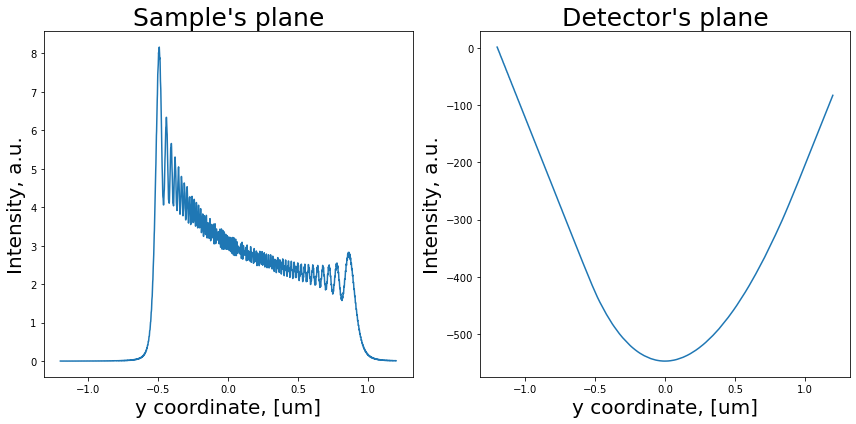

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
# plt.savefig('figures/beam_x.pdf')
plt.show()

In [8]:
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, frame_size)
wf0_y = aperture_wf(y_arr, f + defoc, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, y_arr, dist, wl)

In [9]:
bsteps = barcode_steps(x_arr[-1] - x_arr[0], bar_size, rnd_div, step_size, n_frames)
bs_t = barcode(x_arr, bsteps, sigma, atn, step_size, n_frames)

In [10]:
%time wf1_x = fraunhofer_2d(wf0_x * bs_t, x_arr, xx_arr, dist, wl)

CPU times: user 16.3 s, sys: 36.7 ms, total: 16.4 s
Wall time: 1.39 s


In [11]:
%time data = make_frames(1e2 * wf0_x * bs_t / wl / (f + defoc), wf1_y, x_arr, xx_arr, dist, wl)

CPU times: user 37.5 s, sys: 1.14 s, total: 38.6 s
Wall time: 3.41 s


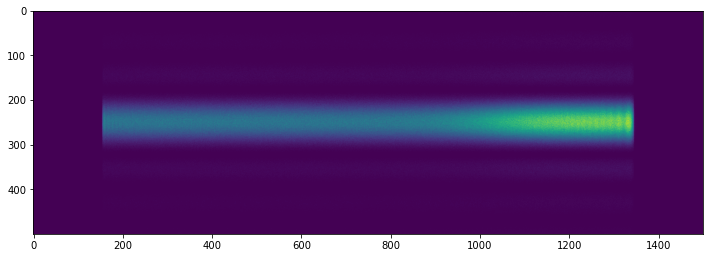

In [12]:
%matplotlib inline
frame_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(data[frame_idx, 750:1250, 250:1750], cmap='viridis')
plt.show()

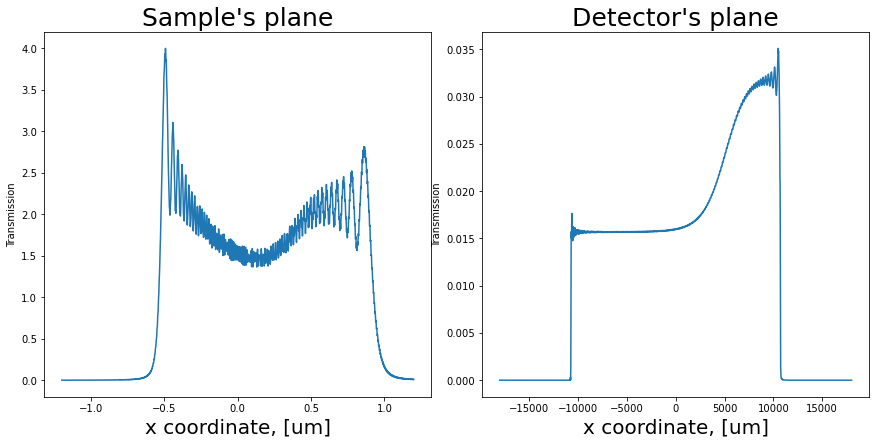

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(x_arr, np.abs(wf0_x * bs_t)[0]**2)
axes[1].plot(xx_arr, np.abs(wf1_x * wf1_y.max() / wl**2 / (f + defoc) / dist)[0]**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Transmission')
plt.tight_layout(pad=0.1)
plt.show()
# plt.savefig('figures/barcode.pdf')

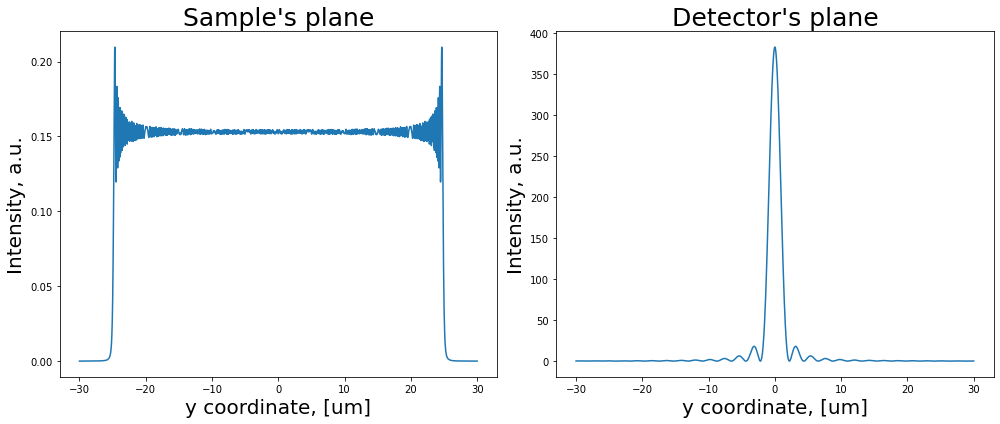

In [16]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(y_arr, np.abs(wf1_y)**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_y.pdf')

In [13]:
ptych = i0 * np.abs(wf1_x * wf1_y.max() / wl**2 / (f + defoc) / dist)**2

In [36]:
%time whitefield = make_whitefield(data, mask)

CPU times: user 4.32 s, sys: 940 ms, total: 5.26 s
Wall time: 458 ms


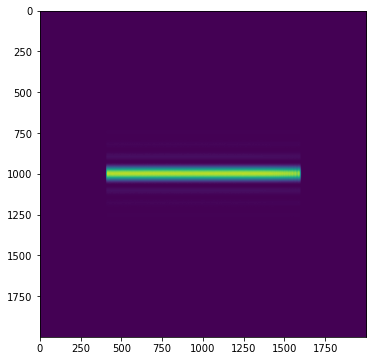

In [37]:
mask = np.ones((frame_size, frame_size), dtype=np.uint8)
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(whitefield)
plt.show()

In [11]:
pixel_vector = np.array([7.5e-5, 7.5e-5, 0])
unit_vector_fs = np.array([0, -1, 0])
unit_vector_ss = np.array([-1, 0, 0])

In [21]:
def basis_vectors(pixel_vector, unit_vector_fs, unit_vector_ss, n_frames, flip_axes=False):
    _vec_fs = np.tile(pixel_vector * unit_vector_fs, (n_frames, 1))
    _vec_ss = np.tile(pixel_vector * unit_vector_ss, (n_frames, 1))
    if flip_axes:
        return np.stack((_vec_ss, _vec_fs), axis=1)
    else:
        return np.stack((_vec_fs, _vec_ss), axis=1)
    
def translation(n_frames, step_size):
    t_arr = np.zeros((n_frames, 3), dtype=np.float64)
    t_arr[:, 0] = np.arange(0, n_frames) * step_size
    return t_arr

# st_sim

In [2]:
from st_sim import STSim, INIParser

In [3]:
ini_parser = INIParser.read_ini('config.ini')
attr_dict = {'exp_geom': {('defoc', 'float'), ('det_dist', 'float'),
                          ('step_size', 'float'), ('n_frames', 'int'),
                          ('frame_size', 'int')},
             'source':   {('i0', 'float'), ('wl', 'float')},
             'lens':     {('ap_x', 'float'), ('ap_y', 'float'),
                          ('focus', 'float'), ('alpha', 'float')},
             'barcode':  {('bar_size', 'float'), ('bar_sigma', 'float'),
                          ('attenuation', 'float'), ('random_dev', 'float')}}

param_dict = {}
for section in attr_dict:
    for option, fmt in attr_dict[section]:
        if fmt == 'float':
            param_dict[option] = ini_parser.getfloat(section, option)
        elif fmt == 'int':
            param_dict[option] = ini_parser.getint(section, option)
        else:
            raise ValueError("Wrong format key '{0:s}' of option '{1:s}'".format(fmt, option))
print(param_dict)

{'defoc': 0.0001, 'frame_size': 2000, 'n_frames': 300, 'det_dist': 1.5, 'step_size': 5e-08, 'i0': 10000000.0, 'wl': 7.29e-11, 'ap_x': 1.5e-05, 'ap_y': 3e-05, 'alpha': 0.1, 'focus': 0.002, 'random_dev': 0.3, 'bar_sigma': 1e-07, 'attenuation': 0.6, 'bar_size': 3e-06}


In [4]:
ini_parser = INIParser.ini_parser()
for section in attr_dict:
    ini_parser[section] = {option: param_dict[option]
                           for option, fmt in attr_dict[section]}
with open('test.ini', 'w') as ini_file:
    ini_parser.write(ini_file)

In [3]:
st_scan = STSim.import_ini('config.ini')

In [4]:
st_scan.bsteps

array([1.58068338e-06, 4.69561180e-06, 7.44757593e-06, 1.05087374e-05,
       1.36489344e-05, 1.62905574e-05])

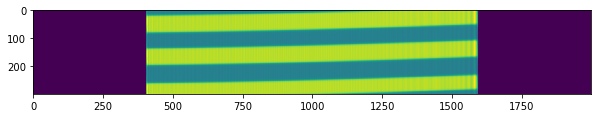

In [37]:
%matplotlib inline
ptych = np.abs(st_scan.wf1_x * st_scan.c_y / st_scan.wl**2 / (st_scan.focus + st_scan.defoc) / st_scan.det_dist)**2
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(ptych, cmap='viridis')
plt.show()

In [39]:
st_scan.ap_x * st_scan.ap_y, ptych.max()

(1.5000000000000002e-09, 1.6693329570143464e-13)